In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import scipy

from sklearn.metrics import RocCurveDisplay
from sklearn import metrics


## Hosmer- Lemshow Chi-Squared Test

$HL = \sum_{j=1}^g\frac{(O_j-n_j\pi_j)^2}{n_j\pi_j(1-\pi_j)}$

In [2]:
#The null hypothesis is that the observed and expected proportions are the same across all doses. The alternative hypothesis is that the observed and expected proportions are not the same.
def hosmer_lemshow(prob, y, sizes):
    HL = 0
    for bucket in zip(prob, y, sizes):
        n_j = bucket[2]
        O_j = bucket[2] * bucket[1]
        pi_j = bucket[0]
        HL += (O_j - pi_j*n_j)**2/(n_j*pi_j*(1-pi_j))
    p_value = 1 - stats.chi2.cdf(HL , len(y) - 2)
    return p_value

## Utils

In [3]:
def color_test(p_value):
    p_value = round(p_value,2)
    p_value = '\033[32m' + str(p_value) if p_value>0.1 else '\033[33m' + str(p_value) if p_value>0.05 else '\033[31m' + str(p_value)
    p_value += '\033[0m'
    return p_value

In [4]:
def run_experiment(prob, y, buckets=20):
    # Bucketting based on predicted probabilities
    df = pd.DataFrame(data={"predicted": prob, "real": y})
    df["bucket"] = 0
    for j in range(1,buckets):
        less_range = np.quantile(df.predicted,j/buckets)
        df["bucket"] = [df.bucket[j]+1 if df["predicted"][j]>less_range else df.bucket[j] for j in range(len(df.bucket))]
    stats_for_bucket = df.groupby('bucket').mean()
    stats_for_bucket["size"] = df.groupby('bucket').count()["predicted"]

    # Plot realised vs observed probabilities
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    ax[0].plot([0,1],[0,1], color="maroon", label="Expected")

    # Best fit
    x = np.linspace(np.min(stats_for_bucket.predicted),np.max(stats_for_bucket.predicted),100)
    def fit_func(x, a, b, c, d, e):
        return (a/(1+np.exp(-b*(x-c)))+d+e*x)
    a = np.max(stats_for_bucket.real)
    b = 4
    c = np.median(stats_for_bucket.predicted)
    d = np.min(stats_for_bucket.real)
    e = 0
    fit, _ = scipy.optimize.curve_fit(fit_func, stats_for_bucket.predicted, stats_for_bucket.real,[a, b, c, d, e])
    p = lambda x: fit_func(x,*fit)

    ax[0].plot(x,[p(x) for x in x], color="green", label="Best fit")
    ax[0].scatter(stats_for_bucket.predicted, stats_for_bucket.real, color="gold")
    ax[0].set_xlabel("Real")
    ax[0].set_ylabel("Predicted")
    ax[0].legend()

    # ROC
    display = RocCurveDisplay.from_predictions(
        y,
        prob,
        name=f"Discriminatory power",
        color="darkorange",
        ax=ax[1]
    )
    _ = display.ax_.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title="Discriminatory power",
    )
    ax[1].plot([0,1],[0,1], color="maroon")
    plt.show()

    print(f"Best sigmoid: {fit}\n")


    # Statistical test

    ## Wilcoxon-signed rank
    print(f"Wilcoxon scipy:\nOne sided: {color_test(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real, alternative='greater')[1])}\nTwo sided: {color_test(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real)[1])}\n")

    ## T-test
    print(f"T-test scipy:\nOne sided: {color_test(stats.ttest_ind(prob, y, alternative='greater')[1])}\nTwo sided: {color_test(stats.ttest_ind(prob, y)[1])}\n")

    ## Hosmer-Lemshow
    print(f"Hosmer-Lemshow:\nTwo sided: {color_test(hosmer_lemshow(stats_for_bucket.predicted, stats_for_bucket.real, stats_for_bucket["size"]))}\n" )

    ## Kolmogorow-Smirnov- for some reason I believe alternative hypothesis is reversed when comparing to other tests
    print(f"Kolmogorow-Smirnov:\nOne sided: {color_test(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real, alternative='less')[1])}\nTwo sided: {color_test(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real).pvalue)}\n" )

    # Mean squared error
    print(f"MSE: {np.mean((stats_for_bucket.predicted-stats_for_bucket.real)**2)}")

    

In [5]:
def just_p_values(prob, y, buckets=20, p_values = None):
    # Bucketting based on predicted probabilities
    df = pd.DataFrame(data={"predicted": prob, "real": y})
    df["bucket"] = 0
    for j in range(1,buckets):
        less_range = np.quantile(df.predicted,j/buckets)
        df["bucket"] = [df.bucket[j]+1 if df["predicted"][j]>less_range else df.bucket[j] for j in range(len(df.bucket))]
    stats_for_bucket = df.groupby('bucket').mean()
    stats_for_bucket["size"] = df.groupby('bucket').count()["predicted"]

    # Statistical test
    if p_values == None:
        p_values = {key:[] for key in ["Wilcoxon One sided", "Wilcoxon Two sided", "T-test One sided", "T-test Two sided", "Hosmer-Lemshow Two sided", "Kolmogorow-Smirnov One sided", "Kolmogorow-Smirnov Two sided"]}
    
    ## Wilcoxon-signed rank
    p_values["Wilcoxon One sided"].append(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real, alternative='greater')[1])
    p_values["Wilcoxon Two sided"].append(stats.wilcoxon(stats_for_bucket.predicted, stats_for_bucket.real)[1])
    
    ## T-test
    p_values["T-test One sided"].append(stats.ttest_ind(prob, y, alternative='greater')[1])
    p_values["T-test Two sided"].append(stats.ttest_ind(prob, y)[1])
    
    ## Hosmer-Lemshow
    p_values["Hosmer-Lemshow Two sided"].append(hosmer_lemshow(stats_for_bucket.predicted, stats_for_bucket.real, stats_for_bucket["size"]))
    
    ## Kolmogorow-Smirnov
    p_values["Kolmogorow-Smirnov One sided"].append(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real, alternative='less')[1])
    p_values["Kolmogorow-Smirnov Two sided"].append(stats.ks_2samp(stats_for_bucket.predicted, stats_for_bucket.real)[1])
    
    return p_values

## Variables

In [6]:
# Sample size for all experiments
n = 2000

# Number of buckets for all experiments
buckets = 20

# Calibrated model

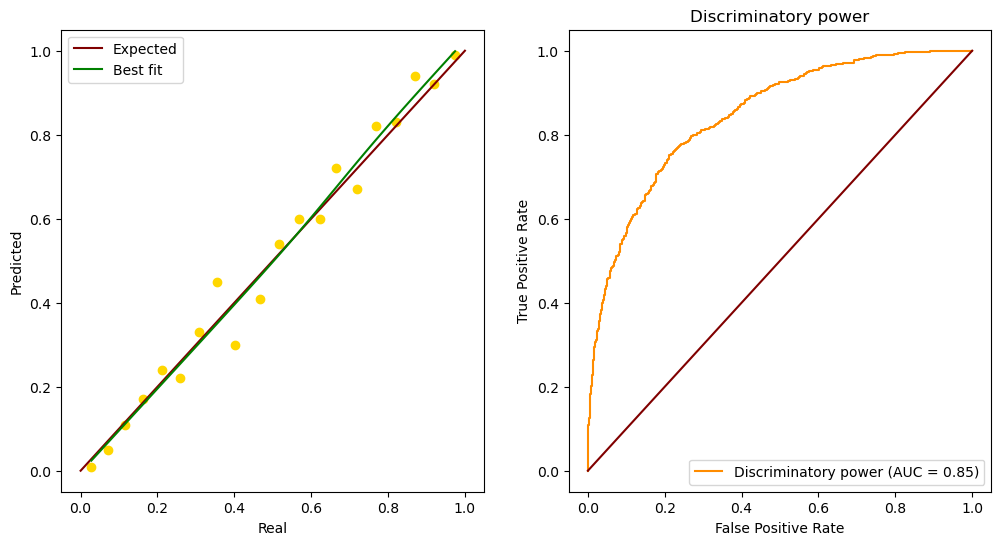

Best sigmoid: [ 3.27710908e-02  1.38346839e+01  6.66246541e-01 -3.72646120e-03
  9.95754017e-01]

Wilcoxon scipy:
One sided: 0.73
Two sided: 0.57

T-test scipy:
One sided: 0.65
Two sided: 0.7

Hosmer-Lemshow:
Two sided: 0.19

Kolmogorow-Smirnov:
One sided: 0.95
Two sided: 1.0

MSE: 0.0020559129189556347


In [7]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)

run_experiment(prob, y, buckets)

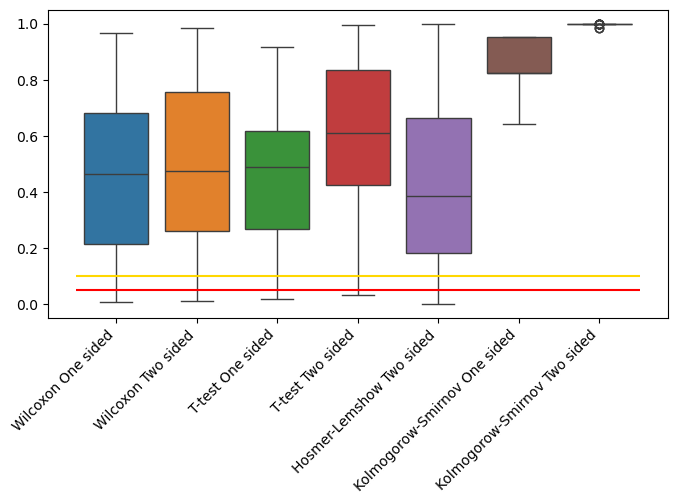

In [8]:
p_values = None
for _ in range(100):
    prob = np.random.uniform(0,1,n)
    y = ((prob + np.random.uniform(-1/2,1/2,n))>1/2).astype(int)

    p_values = just_p_values(prob, y, buckets, p_values) 
p_values = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax,
               data = p_values)
plt.xticks(rotation=45, ha='right')
plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
plt.show()


# Model biased favoring class 1

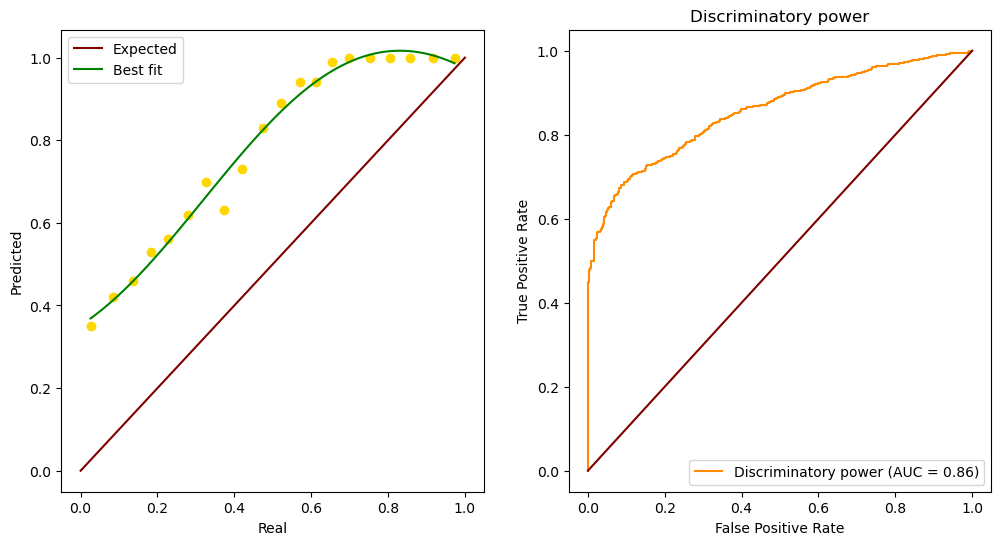

Best sigmoid: [ 3.72332857  2.97658146  0.31939753 -0.68561046 -1.6297814 ]

Wilcoxon scipy:
One sided: 1.0
Two sided: 0.0

T-test scipy:
One sided: 1.0
Two sided: 0.0

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 1.0
Two sided: 0.08

MSE: 0.090383833238966


In [9]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.uniform(-1/2,1/2,n) + 1/3)>1/2).astype(int)

run_experiment(prob, y, buckets)

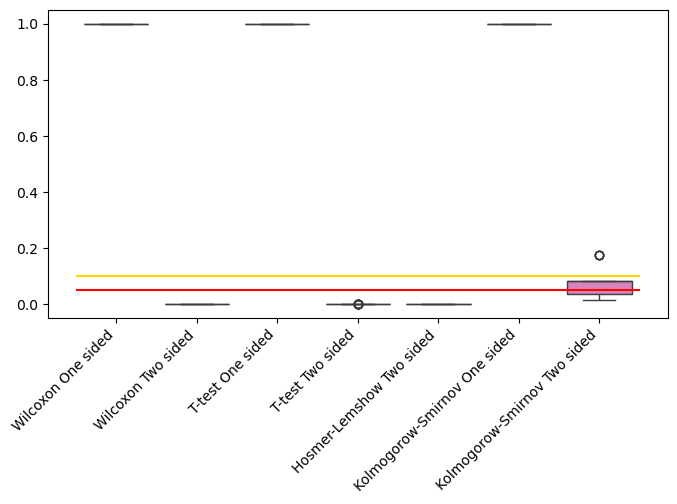

In [10]:
p_values = None
for _ in range(100):
    prob = np.random.uniform(0,1,n)
    y = ((prob + np.random.uniform(-1/2,1/2,n) + 1/3)>1/2).astype(int)

    p_values = just_p_values(prob, y, buckets, p_values) 
p_values = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax,
               data = p_values)
plt.xticks(rotation=45, ha='right')
plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
plt.show()

#  Model biased favoring class 0

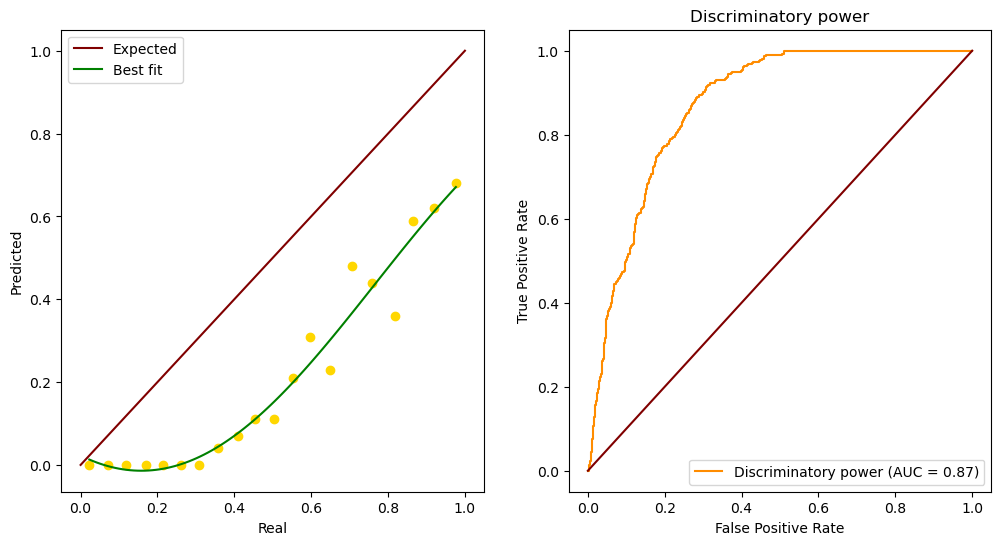

Best sigmoid: [ 6.83527504  2.12277309  0.76579828 -1.10126905 -2.45506767]

Wilcoxon scipy:
One sided: 0.0
Two sided: 0.0

T-test scipy:
One sided: 0.0
Two sided: 0.0

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.02
Two sided: 0.03

MSE: 0.0869152876195716


In [11]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.uniform(-1/2,1/2,n) - 1/3)>1/2).astype(int)

run_experiment(prob, y, buckets)

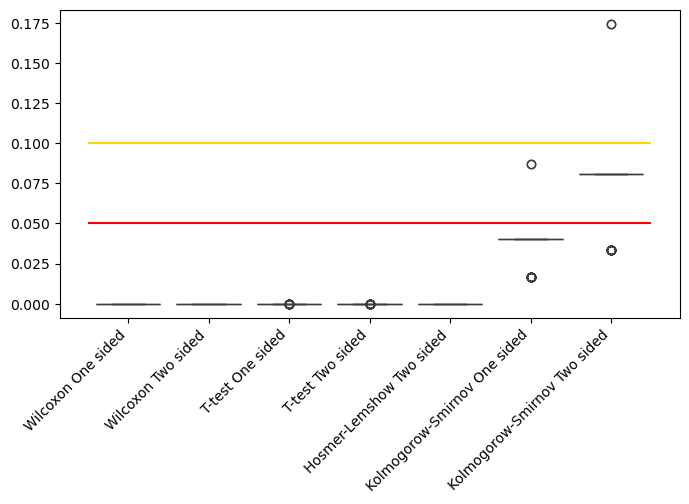

In [12]:
p_values = None
for _ in range(100):
    prob = np.random.uniform(0,1,n)
    y = ((prob + np.random.uniform(-1/2,1/2,n) - 1/3)>1/2).astype(int)

    p_values = just_p_values(prob, y, buckets, p_values) 
p_values = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax,
               data = p_values)
plt.xticks(rotation=45, ha='right')
plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
plt.show()

# Overfitted model

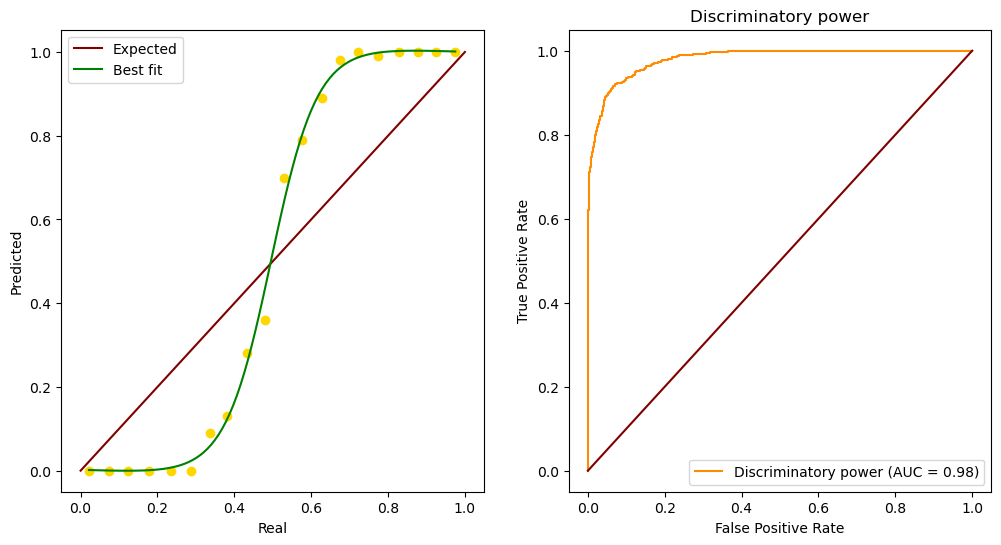

Best sigmoid: [ 1.03197815e+00  1.66929497e+01  4.95434626e-01  1.84144622e-03
 -3.30939241e-02]

Wilcoxon scipy:
One sided: 0.59
Two sided: 0.84

T-test scipy:
One sided: 0.73
Two sided: 0.55

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.17
Two sided: 0.17

MSE: 0.03812824200355831


In [13]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.normal(0,1/10,n))>1/2).astype(int)

run_experiment(prob, y, buckets)


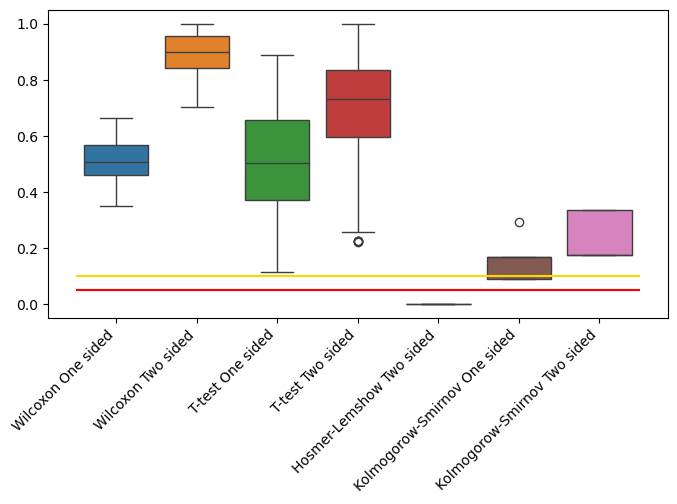

In [14]:
p_values = None
for _ in range(100):
    prob = np.random.uniform(0,1,n)
    y = ((prob + np.random.normal(0,1/10,n))>1/2).astype(int)

    p_values = just_p_values(prob, y, buckets, p_values) 
p_values = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax,
               data = p_values)
plt.xticks(rotation=45, ha='right')
plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
plt.show()

# Underfitted model

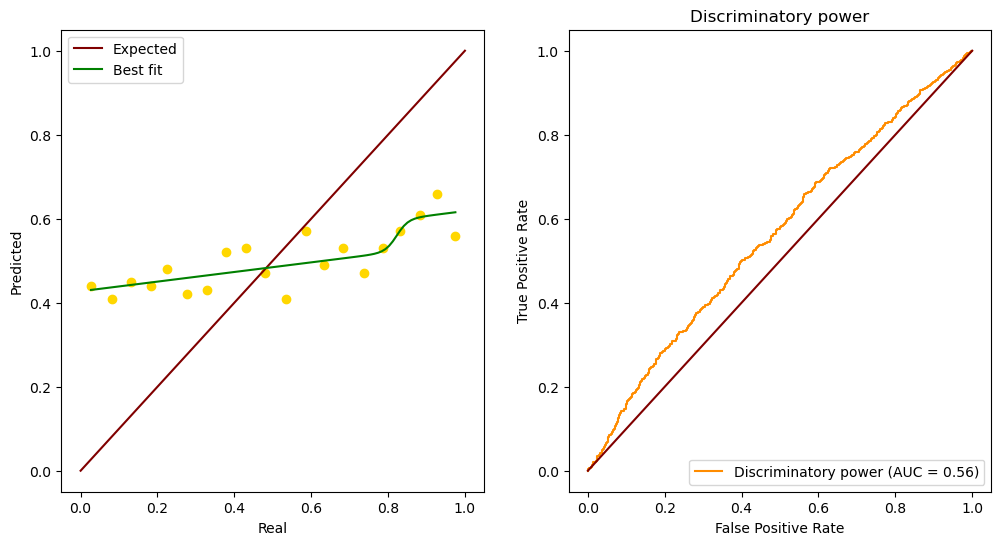

Best sigmoid: [ 0.0762548  66.70442707  0.82251903  0.42732509  0.11463445]

Wilcoxon scipy:
One sided: 0.38
Two sided: 0.76

T-test scipy:
One sided: 0.31
Two sided: 0.61

Hosmer-Lemshow:
Two sided: 0.0

Kolmogorow-Smirnov:
One sided: 0.09
Two sided: 0.08

MSE: 0.0578093327863274


In [15]:
# Sample generation
prob = np.random.uniform(0,1,n)
y = ((prob + np.random.normal(0,2,n))>1/2).astype(int)

run_experiment(prob, y, buckets)

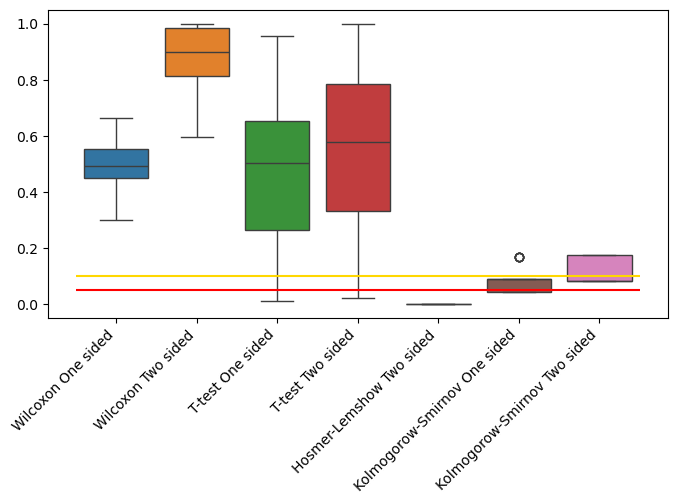

In [16]:
p_values = None
for _ in range(100):
    prob = np.random.uniform(0,1,n)
    y = ((prob + np.random.normal(0,2,n))>1/2).astype(int)

    p_values = just_p_values(prob, y, buckets, p_values) 
p_values = pd.DataFrame(p_values)

fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(ax=ax,
               data = p_values)
plt.xticks(rotation=45, ha='right')
plt.hlines([0.05,0.1],-1/2,p_values.shape[1]-1/2, colors=["Red","Gold"])
plt.show()

In [17]:
# Last model has highest discriminatory power this is probably why neural networks are uncalibrated models because they focus on discriminatory power
# Try focal loss